# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

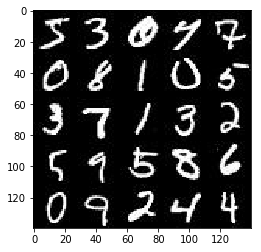

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

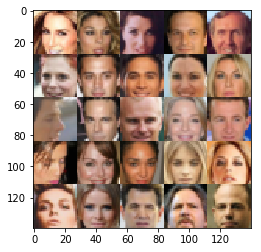

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real') 
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    learning_rate = tf.placeholder(tf.float32,name='learning_rate')
    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha=0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(images, 128, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x128
        
        x2 = tf.layers.conv2d(relu1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * x2, x2)
        # 8x8x256
        
        x3 = tf.layers.conv2d(relu2, 512, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * x3, x3)
        # 4x4x512

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha=0.1
    reuse = not is_train
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha * x3, x3)
        # 28x28x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=1, padding='same')
        # 28x28x3 now
        
        out = tf.tanh(logits)
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    smooth = 0.1
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
    g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _, image_width, image_height, image_channels = data_shape
    input_real, input_z, lr = model_inputs(image_width, image_height,image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z,image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr:learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})
                #_ = sess.run(g_opt, feed_dict={input_z: batch_z, lr:learning_rate})

                if steps % 10 == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % 100 == 0:
                    show_generator_output(sess, 50, input_z, image_channels, data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.6747... Generator Loss: 2.1570
Epoch 1/2... Discriminator Loss: 0.4211... Generator Loss: 7.9505
Epoch 1/2... Discriminator Loss: 0.7386... Generator Loss: 24.3860
Epoch 1/2... Discriminator Loss: 2.1173... Generator Loss: 9.2266
Epoch 1/2... Discriminator Loss: 0.4209... Generator Loss: 7.9057
Epoch 1/2... Discriminator Loss: 0.4209... Generator Loss: 3.5768
Epoch 1/2... Discriminator Loss: 0.3888... Generator Loss: 4.9086
Epoch 1/2... Discriminator Loss: 0.7658... Generator Loss: 2.3669
Epoch 1/2... Discriminator Loss: 0.9502... Generator Loss: 1.4496
Epoch 1/2... Discriminator Loss: 1.0028... Generator Loss: 2.2325


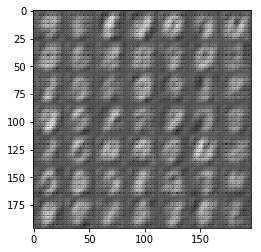

Epoch 1/2... Discriminator Loss: 2.3809... Generator Loss: 0.1766
Epoch 1/2... Discriminator Loss: 1.0509... Generator Loss: 1.0358
Epoch 1/2... Discriminator Loss: 1.2409... Generator Loss: 0.7527
Epoch 1/2... Discriminator Loss: 1.4985... Generator Loss: 2.3897
Epoch 1/2... Discriminator Loss: 1.2131... Generator Loss: 0.7817
Epoch 1/2... Discriminator Loss: 1.0705... Generator Loss: 1.5609
Epoch 1/2... Discriminator Loss: 1.5130... Generator Loss: 0.9920
Epoch 1/2... Discriminator Loss: 1.1790... Generator Loss: 1.2161
Epoch 1/2... Discriminator Loss: 0.9589... Generator Loss: 1.3089
Epoch 1/2... Discriminator Loss: 1.1037... Generator Loss: 0.9139


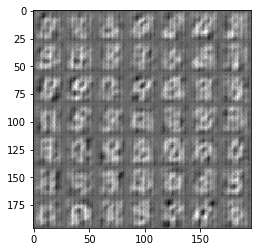

Epoch 1/2... Discriminator Loss: 1.2898... Generator Loss: 1.1271
Epoch 1/2... Discriminator Loss: 1.1171... Generator Loss: 0.8289
Epoch 1/2... Discriminator Loss: 0.8774... Generator Loss: 1.1326
Epoch 1/2... Discriminator Loss: 1.1274... Generator Loss: 0.9655
Epoch 1/2... Discriminator Loss: 1.1469... Generator Loss: 1.2648
Epoch 1/2... Discriminator Loss: 0.9687... Generator Loss: 2.1890
Epoch 1/2... Discriminator Loss: 1.1234... Generator Loss: 1.4188
Epoch 1/2... Discriminator Loss: 1.3494... Generator Loss: 0.6244
Epoch 1/2... Discriminator Loss: 1.0886... Generator Loss: 1.0825
Epoch 1/2... Discriminator Loss: 1.5231... Generator Loss: 0.4796


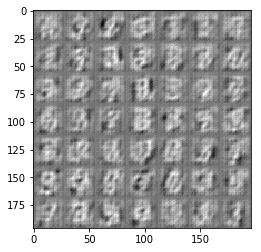

Epoch 1/2... Discriminator Loss: 1.0401... Generator Loss: 1.0211
Epoch 1/2... Discriminator Loss: 1.2021... Generator Loss: 0.7002
Epoch 1/2... Discriminator Loss: 1.4602... Generator Loss: 0.4636
Epoch 1/2... Discriminator Loss: 0.9218... Generator Loss: 1.0587
Epoch 1/2... Discriminator Loss: 0.8418... Generator Loss: 1.5943
Epoch 1/2... Discriminator Loss: 1.5008... Generator Loss: 0.4850
Epoch 1/2... Discriminator Loss: 1.3357... Generator Loss: 0.5847
Epoch 1/2... Discriminator Loss: 0.9917... Generator Loss: 0.9051
Epoch 1/2... Discriminator Loss: 0.9053... Generator Loss: 1.2108
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.5664


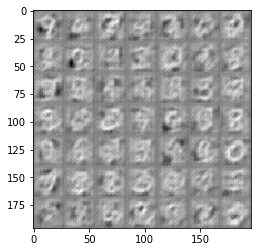

Epoch 1/2... Discriminator Loss: 1.4138... Generator Loss: 0.6587
Epoch 1/2... Discriminator Loss: 1.0384... Generator Loss: 1.0873
Epoch 1/2... Discriminator Loss: 1.3762... Generator Loss: 0.6440
Epoch 1/2... Discriminator Loss: 1.4578... Generator Loss: 0.5199
Epoch 1/2... Discriminator Loss: 1.1454... Generator Loss: 0.9100
Epoch 1/2... Discriminator Loss: 1.3826... Generator Loss: 0.6426
Epoch 1/2... Discriminator Loss: 1.4087... Generator Loss: 0.6021
Epoch 1/2... Discriminator Loss: 1.7461... Generator Loss: 2.5142
Epoch 1/2... Discriminator Loss: 1.3479... Generator Loss: 0.9610
Epoch 1/2... Discriminator Loss: 1.0833... Generator Loss: 1.0350


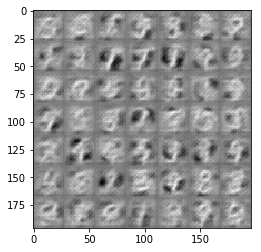

Epoch 1/2... Discriminator Loss: 1.2252... Generator Loss: 0.7404
Epoch 1/2... Discriminator Loss: 1.3714... Generator Loss: 0.5835
Epoch 1/2... Discriminator Loss: 0.9224... Generator Loss: 1.2005
Epoch 1/2... Discriminator Loss: 1.1774... Generator Loss: 0.7993
Epoch 1/2... Discriminator Loss: 1.0697... Generator Loss: 1.0997
Epoch 1/2... Discriminator Loss: 1.0116... Generator Loss: 1.6126
Epoch 1/2... Discriminator Loss: 1.1165... Generator Loss: 1.2321
Epoch 1/2... Discriminator Loss: 1.2626... Generator Loss: 1.5168
Epoch 1/2... Discriminator Loss: 0.8947... Generator Loss: 1.0747
Epoch 1/2... Discriminator Loss: 1.2623... Generator Loss: 0.8766


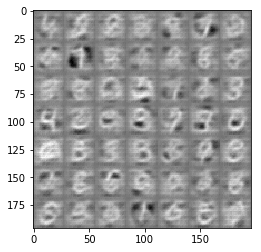

Epoch 1/2... Discriminator Loss: 1.0955... Generator Loss: 1.1452
Epoch 1/2... Discriminator Loss: 1.0259... Generator Loss: 0.9270
Epoch 1/2... Discriminator Loss: 1.2554... Generator Loss: 0.6542
Epoch 1/2... Discriminator Loss: 0.9941... Generator Loss: 1.2369
Epoch 1/2... Discriminator Loss: 1.2025... Generator Loss: 1.0274
Epoch 1/2... Discriminator Loss: 1.0801... Generator Loss: 1.0477
Epoch 1/2... Discriminator Loss: 1.3227... Generator Loss: 1.7177
Epoch 1/2... Discriminator Loss: 0.9974... Generator Loss: 1.1084
Epoch 1/2... Discriminator Loss: 1.4369... Generator Loss: 0.4830
Epoch 1/2... Discriminator Loss: 0.8410... Generator Loss: 1.3726


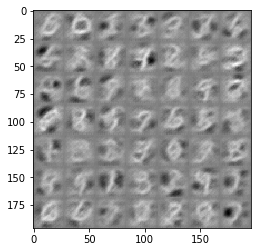

Epoch 1/2... Discriminator Loss: 1.4650... Generator Loss: 0.5687
Epoch 1/2... Discriminator Loss: 1.3987... Generator Loss: 0.5035
Epoch 1/2... Discriminator Loss: 1.1782... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 1.2015... Generator Loss: 0.8436
Epoch 1/2... Discriminator Loss: 0.9222... Generator Loss: 1.6843
Epoch 1/2... Discriminator Loss: 1.1115... Generator Loss: 2.3251
Epoch 1/2... Discriminator Loss: 1.0276... Generator Loss: 1.0093
Epoch 1/2... Discriminator Loss: 1.1495... Generator Loss: 1.3297
Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 0.5539
Epoch 1/2... Discriminator Loss: 1.5417... Generator Loss: 0.4356


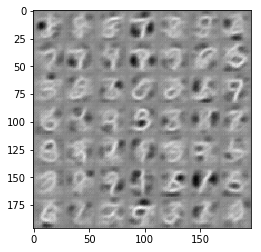

Epoch 1/2... Discriminator Loss: 1.1101... Generator Loss: 0.7873
Epoch 1/2... Discriminator Loss: 1.0750... Generator Loss: 1.0099
Epoch 1/2... Discriminator Loss: 1.1011... Generator Loss: 0.8720
Epoch 1/2... Discriminator Loss: 1.0261... Generator Loss: 1.5267
Epoch 1/2... Discriminator Loss: 0.9935... Generator Loss: 0.9744
Epoch 1/2... Discriminator Loss: 1.0546... Generator Loss: 0.9397
Epoch 1/2... Discriminator Loss: 1.3370... Generator Loss: 0.6636
Epoch 1/2... Discriminator Loss: 1.2478... Generator Loss: 0.6417
Epoch 1/2... Discriminator Loss: 1.1172... Generator Loss: 1.0353
Epoch 1/2... Discriminator Loss: 1.0978... Generator Loss: 1.0195


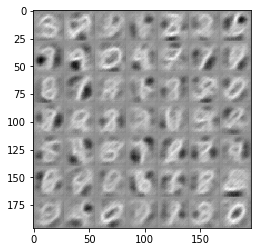

Epoch 1/2... Discriminator Loss: 1.1711... Generator Loss: 0.9673
Epoch 1/2... Discriminator Loss: 1.2258... Generator Loss: 0.8975
Epoch 1/2... Discriminator Loss: 1.0828... Generator Loss: 1.0451
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 0.8138
Epoch 1/2... Discriminator Loss: 0.9552... Generator Loss: 1.0359
Epoch 1/2... Discriminator Loss: 0.9624... Generator Loss: 1.2897
Epoch 1/2... Discriminator Loss: 1.0716... Generator Loss: 1.0175
Epoch 1/2... Discriminator Loss: 1.3622... Generator Loss: 2.4863
Epoch 1/2... Discriminator Loss: 1.1142... Generator Loss: 0.8325
Epoch 1/2... Discriminator Loss: 1.2775... Generator Loss: 0.6093


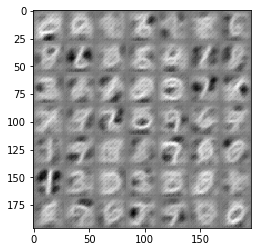

Epoch 1/2... Discriminator Loss: 1.2786... Generator Loss: 0.6062
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.8400
Epoch 1/2... Discriminator Loss: 1.1336... Generator Loss: 0.6795
Epoch 1/2... Discriminator Loss: 1.3412... Generator Loss: 0.5393
Epoch 1/2... Discriminator Loss: 0.8714... Generator Loss: 1.2101
Epoch 1/2... Discriminator Loss: 1.0860... Generator Loss: 1.0177
Epoch 1/2... Discriminator Loss: 1.0440... Generator Loss: 0.9907
Epoch 1/2... Discriminator Loss: 1.1037... Generator Loss: 0.7976
Epoch 1/2... Discriminator Loss: 0.8468... Generator Loss: 1.2006
Epoch 1/2... Discriminator Loss: 1.3947... Generator Loss: 0.5867


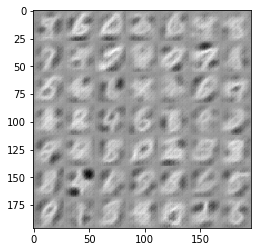

Epoch 1/2... Discriminator Loss: 1.0161... Generator Loss: 1.1397
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 1.4192
Epoch 1/2... Discriminator Loss: 1.1198... Generator Loss: 0.8268
Epoch 1/2... Discriminator Loss: 1.4079... Generator Loss: 0.5143
Epoch 1/2... Discriminator Loss: 1.0987... Generator Loss: 1.2918
Epoch 1/2... Discriminator Loss: 1.1024... Generator Loss: 0.8546
Epoch 1/2... Discriminator Loss: 1.2938... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 1.0111... Generator Loss: 0.8621
Epoch 1/2... Discriminator Loss: 0.9201... Generator Loss: 1.5166
Epoch 1/2... Discriminator Loss: 0.6961... Generator Loss: 1.9331


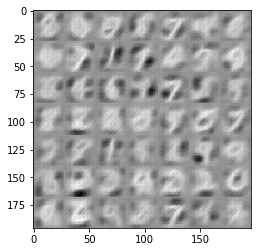

Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 1.0360
Epoch 1/2... Discriminator Loss: 1.3139... Generator Loss: 0.5736
Epoch 1/2... Discriminator Loss: 1.4361... Generator Loss: 0.5342
Epoch 1/2... Discriminator Loss: 0.8875... Generator Loss: 1.1354
Epoch 1/2... Discriminator Loss: 1.0617... Generator Loss: 0.7715
Epoch 1/2... Discriminator Loss: 1.5509... Generator Loss: 0.4305
Epoch 1/2... Discriminator Loss: 1.2427... Generator Loss: 0.6958
Epoch 1/2... Discriminator Loss: 1.1130... Generator Loss: 0.7922
Epoch 1/2... Discriminator Loss: 1.0485... Generator Loss: 0.9628
Epoch 1/2... Discriminator Loss: 0.9998... Generator Loss: 1.0357


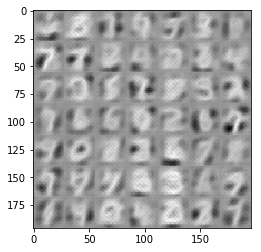

Epoch 1/2... Discriminator Loss: 1.3072... Generator Loss: 2.5612
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.5441
Epoch 1/2... Discriminator Loss: 1.5953... Generator Loss: 0.4189
Epoch 1/2... Discriminator Loss: 1.0895... Generator Loss: 0.7910
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 0.6082
Epoch 1/2... Discriminator Loss: 1.6627... Generator Loss: 0.4077
Epoch 1/2... Discriminator Loss: 1.0168... Generator Loss: 1.1821
Epoch 1/2... Discriminator Loss: 0.9670... Generator Loss: 1.2171
Epoch 1/2... Discriminator Loss: 0.8782... Generator Loss: 1.3152
Epoch 1/2... Discriminator Loss: 1.9749... Generator Loss: 0.3123


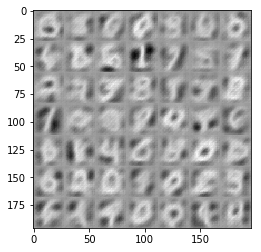

Epoch 1/2... Discriminator Loss: 1.0857... Generator Loss: 0.8917
Epoch 1/2... Discriminator Loss: 1.0220... Generator Loss: 1.1062
Epoch 1/2... Discriminator Loss: 0.9667... Generator Loss: 1.1795
Epoch 1/2... Discriminator Loss: 1.1969... Generator Loss: 0.7457
Epoch 1/2... Discriminator Loss: 0.9078... Generator Loss: 1.0742
Epoch 1/2... Discriminator Loss: 0.9108... Generator Loss: 1.0315
Epoch 1/2... Discriminator Loss: 1.7291... Generator Loss: 0.3522
Epoch 1/2... Discriminator Loss: 1.2995... Generator Loss: 0.5839
Epoch 1/2... Discriminator Loss: 1.6725... Generator Loss: 0.4013
Epoch 1/2... Discriminator Loss: 1.4501... Generator Loss: 0.5024


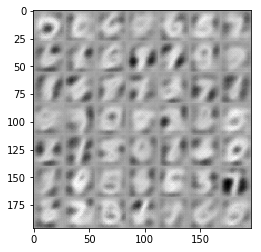

Epoch 1/2... Discriminator Loss: 1.5035... Generator Loss: 0.5269
Epoch 1/2... Discriminator Loss: 0.7612... Generator Loss: 1.6284
Epoch 1/2... Discriminator Loss: 0.9138... Generator Loss: 1.4839
Epoch 1/2... Discriminator Loss: 0.9445... Generator Loss: 1.0303
Epoch 1/2... Discriminator Loss: 1.2517... Generator Loss: 0.6456
Epoch 1/2... Discriminator Loss: 1.1100... Generator Loss: 0.8635
Epoch 1/2... Discriminator Loss: 0.9285... Generator Loss: 1.6007
Epoch 1/2... Discriminator Loss: 1.5810... Generator Loss: 0.4541
Epoch 1/2... Discriminator Loss: 0.9183... Generator Loss: 1.8768
Epoch 1/2... Discriminator Loss: 1.1377... Generator Loss: 0.7600


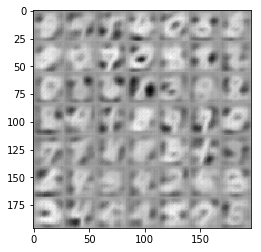

Epoch 1/2... Discriminator Loss: 1.4362... Generator Loss: 0.6490
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.6352
Epoch 1/2... Discriminator Loss: 1.1549... Generator Loss: 0.7053
Epoch 1/2... Discriminator Loss: 1.0265... Generator Loss: 0.7935
Epoch 1/2... Discriminator Loss: 0.8297... Generator Loss: 1.1946
Epoch 1/2... Discriminator Loss: 0.8955... Generator Loss: 1.1323
Epoch 1/2... Discriminator Loss: 1.0971... Generator Loss: 0.7592
Epoch 1/2... Discriminator Loss: 1.6276... Generator Loss: 0.4941
Epoch 1/2... Discriminator Loss: 0.9783... Generator Loss: 1.0496
Epoch 1/2... Discriminator Loss: 1.1701... Generator Loss: 0.7447


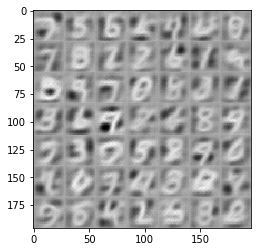

Epoch 1/2... Discriminator Loss: 0.7221... Generator Loss: 1.6469
Epoch 1/2... Discriminator Loss: 1.0818... Generator Loss: 1.0891
Epoch 1/2... Discriminator Loss: 1.3124... Generator Loss: 0.6925
Epoch 1/2... Discriminator Loss: 1.0149... Generator Loss: 0.9924
Epoch 1/2... Discriminator Loss: 1.0521... Generator Loss: 0.9648
Epoch 1/2... Discriminator Loss: 1.4847... Generator Loss: 0.4972
Epoch 1/2... Discriminator Loss: 0.9006... Generator Loss: 1.1712
Epoch 1/2... Discriminator Loss: 0.8138... Generator Loss: 1.2614
Epoch 1/2... Discriminator Loss: 0.8301... Generator Loss: 1.8083
Epoch 1/2... Discriminator Loss: 0.9074... Generator Loss: 0.9693


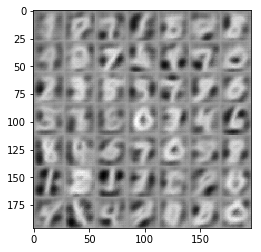

Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 1.8079
Epoch 1/2... Discriminator Loss: 2.0688... Generator Loss: 0.2899
Epoch 1/2... Discriminator Loss: 1.0645... Generator Loss: 0.9462
Epoch 1/2... Discriminator Loss: 1.2238... Generator Loss: 0.6159
Epoch 1/2... Discriminator Loss: 1.0082... Generator Loss: 0.9687
Epoch 1/2... Discriminator Loss: 0.9621... Generator Loss: 1.0631
Epoch 1/2... Discriminator Loss: 0.8909... Generator Loss: 1.0862
Epoch 2/2... Discriminator Loss: 1.0029... Generator Loss: 2.5404
Epoch 2/2... Discriminator Loss: 1.2245... Generator Loss: 1.7540
Epoch 2/2... Discriminator Loss: 0.9352... Generator Loss: 1.1478


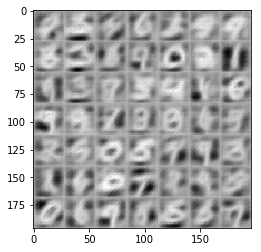

Epoch 2/2... Discriminator Loss: 0.8928... Generator Loss: 1.5280
Epoch 2/2... Discriminator Loss: 1.1964... Generator Loss: 0.7855
Epoch 2/2... Discriminator Loss: 0.9572... Generator Loss: 0.9376
Epoch 2/2... Discriminator Loss: 0.9757... Generator Loss: 1.1137
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 2.3296
Epoch 2/2... Discriminator Loss: 0.9107... Generator Loss: 1.0416
Epoch 2/2... Discriminator Loss: 1.1625... Generator Loss: 0.7006
Epoch 2/2... Discriminator Loss: 1.0984... Generator Loss: 0.8129
Epoch 2/2... Discriminator Loss: 0.8868... Generator Loss: 1.4662
Epoch 2/2... Discriminator Loss: 0.8308... Generator Loss: 1.2810


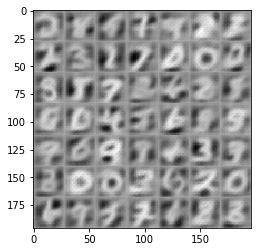

Epoch 2/2... Discriminator Loss: 1.0515... Generator Loss: 1.3537
Epoch 2/2... Discriminator Loss: 0.9714... Generator Loss: 0.9958
Epoch 2/2... Discriminator Loss: 1.0533... Generator Loss: 0.8419
Epoch 2/2... Discriminator Loss: 0.7370... Generator Loss: 1.5715
Epoch 2/2... Discriminator Loss: 1.1396... Generator Loss: 0.8391
Epoch 2/2... Discriminator Loss: 0.5973... Generator Loss: 2.1896
Epoch 2/2... Discriminator Loss: 0.8562... Generator Loss: 1.3147
Epoch 2/2... Discriminator Loss: 1.1382... Generator Loss: 0.9746
Epoch 2/2... Discriminator Loss: 0.8898... Generator Loss: 1.1064
Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 1.0907


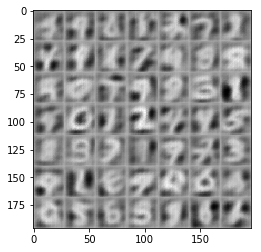

Epoch 2/2... Discriminator Loss: 0.7936... Generator Loss: 1.3630
Epoch 2/2... Discriminator Loss: 0.8067... Generator Loss: 2.0972
Epoch 2/2... Discriminator Loss: 1.0085... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.1711... Generator Loss: 1.9302
Epoch 2/2... Discriminator Loss: 1.1164... Generator Loss: 0.7816
Epoch 2/2... Discriminator Loss: 0.8153... Generator Loss: 1.3819
Epoch 2/2... Discriminator Loss: 0.9400... Generator Loss: 1.0609
Epoch 2/2... Discriminator Loss: 1.0225... Generator Loss: 0.9921
Epoch 2/2... Discriminator Loss: 0.8745... Generator Loss: 1.1886
Epoch 2/2... Discriminator Loss: 0.9675... Generator Loss: 0.9395


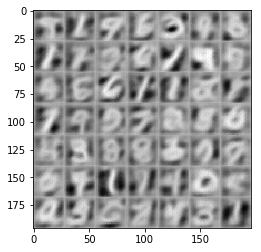

Epoch 2/2... Discriminator Loss: 0.8762... Generator Loss: 1.3581
Epoch 2/2... Discriminator Loss: 0.8611... Generator Loss: 1.4213
Epoch 2/2... Discriminator Loss: 1.4402... Generator Loss: 0.5204
Epoch 2/2... Discriminator Loss: 0.7857... Generator Loss: 1.3449
Epoch 2/2... Discriminator Loss: 1.1575... Generator Loss: 1.8741
Epoch 2/2... Discriminator Loss: 0.8729... Generator Loss: 1.1933
Epoch 2/2... Discriminator Loss: 1.0399... Generator Loss: 1.3743
Epoch 2/2... Discriminator Loss: 0.9495... Generator Loss: 0.9535
Epoch 2/2... Discriminator Loss: 0.7106... Generator Loss: 1.5749
Epoch 2/2... Discriminator Loss: 0.7444... Generator Loss: 1.4499


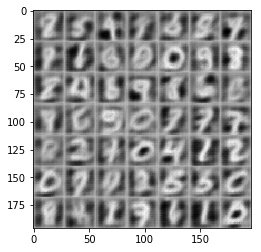

Epoch 2/2... Discriminator Loss: 1.0173... Generator Loss: 1.1344
Epoch 2/2... Discriminator Loss: 1.2584... Generator Loss: 0.6326
Epoch 2/2... Discriminator Loss: 1.1814... Generator Loss: 0.7341
Epoch 2/2... Discriminator Loss: 0.9462... Generator Loss: 1.0556
Epoch 2/2... Discriminator Loss: 0.7583... Generator Loss: 1.6580
Epoch 2/2... Discriminator Loss: 1.1400... Generator Loss: 0.7625
Epoch 2/2... Discriminator Loss: 0.8088... Generator Loss: 1.4019
Epoch 2/2... Discriminator Loss: 0.9915... Generator Loss: 1.2162
Epoch 2/2... Discriminator Loss: 0.8464... Generator Loss: 1.0707
Epoch 2/2... Discriminator Loss: 1.0306... Generator Loss: 0.8856


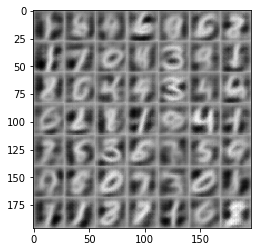

Epoch 2/2... Discriminator Loss: 1.6434... Generator Loss: 0.4678
Epoch 2/2... Discriminator Loss: 0.7906... Generator Loss: 1.2517
Epoch 2/2... Discriminator Loss: 1.1553... Generator Loss: 2.3273
Epoch 2/2... Discriminator Loss: 1.0207... Generator Loss: 1.0330
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 0.9230
Epoch 2/2... Discriminator Loss: 0.7822... Generator Loss: 1.2867
Epoch 2/2... Discriminator Loss: 1.3440... Generator Loss: 0.5903
Epoch 2/2... Discriminator Loss: 1.0514... Generator Loss: 0.9059
Epoch 2/2... Discriminator Loss: 0.9935... Generator Loss: 0.9578
Epoch 2/2... Discriminator Loss: 0.8844... Generator Loss: 1.0481


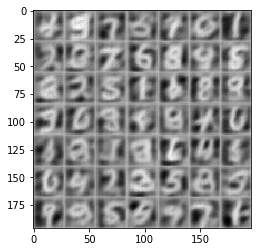

Epoch 2/2... Discriminator Loss: 1.4146... Generator Loss: 0.5214
Epoch 2/2... Discriminator Loss: 0.7814... Generator Loss: 1.8102
Epoch 2/2... Discriminator Loss: 1.1638... Generator Loss: 0.7396
Epoch 2/2... Discriminator Loss: 1.0148... Generator Loss: 0.9601
Epoch 2/2... Discriminator Loss: 1.5701... Generator Loss: 0.4193
Epoch 2/2... Discriminator Loss: 0.9049... Generator Loss: 1.0840
Epoch 2/2... Discriminator Loss: 0.8319... Generator Loss: 1.1035
Epoch 2/2... Discriminator Loss: 0.9724... Generator Loss: 1.3337
Epoch 2/2... Discriminator Loss: 0.9443... Generator Loss: 1.0912
Epoch 2/2... Discriminator Loss: 0.7235... Generator Loss: 1.7276


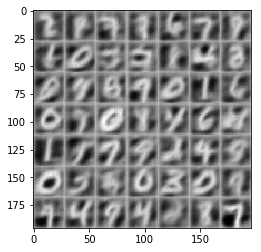

Epoch 2/2... Discriminator Loss: 0.8852... Generator Loss: 1.0619
Epoch 2/2... Discriminator Loss: 0.9624... Generator Loss: 1.0296
Epoch 2/2... Discriminator Loss: 0.9415... Generator Loss: 1.0159
Epoch 2/2... Discriminator Loss: 1.1990... Generator Loss: 0.9585
Epoch 2/2... Discriminator Loss: 1.0053... Generator Loss: 0.8708
Epoch 2/2... Discriminator Loss: 1.0023... Generator Loss: 1.7201
Epoch 2/2... Discriminator Loss: 0.6800... Generator Loss: 1.7099
Epoch 2/2... Discriminator Loss: 0.8542... Generator Loss: 2.1965
Epoch 2/2... Discriminator Loss: 0.8629... Generator Loss: 1.1215
Epoch 2/2... Discriminator Loss: 1.2573... Generator Loss: 0.6419


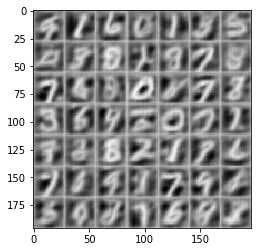

Epoch 2/2... Discriminator Loss: 0.6662... Generator Loss: 1.6909
Epoch 2/2... Discriminator Loss: 1.1413... Generator Loss: 0.8017
Epoch 2/2... Discriminator Loss: 1.7770... Generator Loss: 0.3643
Epoch 2/2... Discriminator Loss: 0.5953... Generator Loss: 1.8348
Epoch 2/2... Discriminator Loss: 1.0775... Generator Loss: 0.8424
Epoch 2/2... Discriminator Loss: 0.8317... Generator Loss: 1.1814
Epoch 2/2... Discriminator Loss: 0.7273... Generator Loss: 1.6819
Epoch 2/2... Discriminator Loss: 0.7835... Generator Loss: 1.5611
Epoch 2/2... Discriminator Loss: 0.9819... Generator Loss: 1.2158
Epoch 2/2... Discriminator Loss: 0.8427... Generator Loss: 1.4816


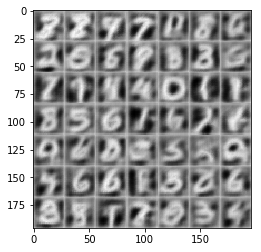

Epoch 2/2... Discriminator Loss: 0.8193... Generator Loss: 1.1945
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.9040
Epoch 2/2... Discriminator Loss: 0.7410... Generator Loss: 1.5477
Epoch 2/2... Discriminator Loss: 1.2037... Generator Loss: 0.7000
Epoch 2/2... Discriminator Loss: 0.8558... Generator Loss: 1.1578
Epoch 2/2... Discriminator Loss: 0.6677... Generator Loss: 1.8530
Epoch 2/2... Discriminator Loss: 0.7880... Generator Loss: 1.6169
Epoch 2/2... Discriminator Loss: 0.7229... Generator Loss: 1.3483
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 0.9814
Epoch 2/2... Discriminator Loss: 0.8174... Generator Loss: 1.2897


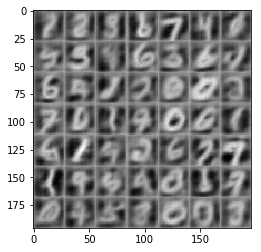

Epoch 2/2... Discriminator Loss: 0.8167... Generator Loss: 1.2795
Epoch 2/2... Discriminator Loss: 1.0169... Generator Loss: 1.0081
Epoch 2/2... Discriminator Loss: 0.6615... Generator Loss: 1.6168
Epoch 2/2... Discriminator Loss: 0.9109... Generator Loss: 1.0215
Epoch 2/2... Discriminator Loss: 1.2345... Generator Loss: 0.8475
Epoch 2/2... Discriminator Loss: 0.7175... Generator Loss: 2.0893
Epoch 2/2... Discriminator Loss: 0.6818... Generator Loss: 1.8912
Epoch 2/2... Discriminator Loss: 0.9203... Generator Loss: 0.9868
Epoch 2/2... Discriminator Loss: 0.8969... Generator Loss: 2.2607
Epoch 2/2... Discriminator Loss: 0.6915... Generator Loss: 1.8285


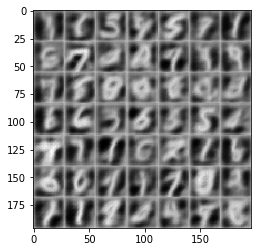

Epoch 2/2... Discriminator Loss: 0.7663... Generator Loss: 1.5569
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.1084
Epoch 2/2... Discriminator Loss: 0.8531... Generator Loss: 1.1405
Epoch 2/2... Discriminator Loss: 0.8725... Generator Loss: 1.0614
Epoch 2/2... Discriminator Loss: 1.1315... Generator Loss: 0.7657
Epoch 2/2... Discriminator Loss: 0.6319... Generator Loss: 1.9530
Epoch 2/2... Discriminator Loss: 0.6956... Generator Loss: 1.3580
Epoch 2/2... Discriminator Loss: 0.6649... Generator Loss: 1.6123
Epoch 2/2... Discriminator Loss: 1.8343... Generator Loss: 0.3804
Epoch 2/2... Discriminator Loss: 0.7838... Generator Loss: 1.8565


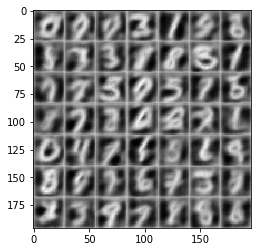

Epoch 2/2... Discriminator Loss: 0.7944... Generator Loss: 2.1319
Epoch 2/2... Discriminator Loss: 1.0103... Generator Loss: 0.9966
Epoch 2/2... Discriminator Loss: 0.8627... Generator Loss: 1.1290
Epoch 2/2... Discriminator Loss: 0.8159... Generator Loss: 1.2038
Epoch 2/2... Discriminator Loss: 0.8997... Generator Loss: 1.0401
Epoch 2/2... Discriminator Loss: 0.8360... Generator Loss: 1.2445
Epoch 2/2... Discriminator Loss: 1.3846... Generator Loss: 0.5854
Epoch 2/2... Discriminator Loss: 0.7462... Generator Loss: 1.5822
Epoch 2/2... Discriminator Loss: 1.3909... Generator Loss: 0.6588
Epoch 2/2... Discriminator Loss: 0.6564... Generator Loss: 1.6187


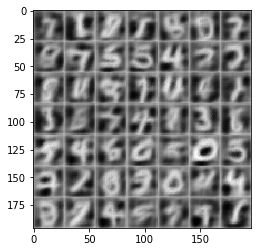

Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 1.1562
Epoch 2/2... Discriminator Loss: 0.9997... Generator Loss: 0.9098
Epoch 2/2... Discriminator Loss: 1.1604... Generator Loss: 0.7697
Epoch 2/2... Discriminator Loss: 0.6234... Generator Loss: 1.8126
Epoch 2/2... Discriminator Loss: 0.8526... Generator Loss: 1.8239
Epoch 2/2... Discriminator Loss: 0.6711... Generator Loss: 1.6188
Epoch 2/2... Discriminator Loss: 0.7717... Generator Loss: 1.3015
Epoch 2/2... Discriminator Loss: 1.0098... Generator Loss: 3.0300
Epoch 2/2... Discriminator Loss: 1.0782... Generator Loss: 0.9865
Epoch 2/2... Discriminator Loss: 0.9031... Generator Loss: 1.0401


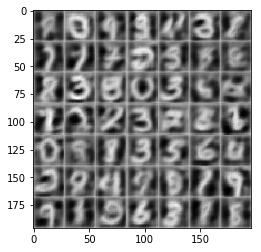

Epoch 2/2... Discriminator Loss: 0.7955... Generator Loss: 1.3040
Epoch 2/2... Discriminator Loss: 0.6871... Generator Loss: 1.4961
Epoch 2/2... Discriminator Loss: 0.8881... Generator Loss: 1.8368
Epoch 2/2... Discriminator Loss: 0.6921... Generator Loss: 1.5627
Epoch 2/2... Discriminator Loss: 1.1533... Generator Loss: 0.8228
Epoch 2/2... Discriminator Loss: 0.5388... Generator Loss: 2.2304
Epoch 2/2... Discriminator Loss: 0.9993... Generator Loss: 0.8870
Epoch 2/2... Discriminator Loss: 0.8874... Generator Loss: 2.0811
Epoch 2/2... Discriminator Loss: 0.7659... Generator Loss: 1.7476
Epoch 2/2... Discriminator Loss: 1.0235... Generator Loss: 0.7772


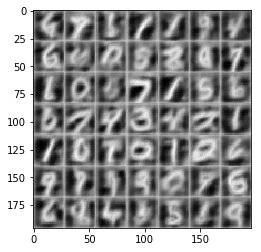

Epoch 2/2... Discriminator Loss: 0.7713... Generator Loss: 1.3515
Epoch 2/2... Discriminator Loss: 0.9519... Generator Loss: 2.7509
Epoch 2/2... Discriminator Loss: 0.9643... Generator Loss: 1.0297
Epoch 2/2... Discriminator Loss: 0.9452... Generator Loss: 0.9686
Epoch 2/2... Discriminator Loss: 0.9637... Generator Loss: 0.9876
Epoch 2/2... Discriminator Loss: 0.8775... Generator Loss: 1.2139
Epoch 2/2... Discriminator Loss: 0.9781... Generator Loss: 0.9206
Epoch 2/2... Discriminator Loss: 0.9622... Generator Loss: 1.0228
Epoch 2/2... Discriminator Loss: 1.2112... Generator Loss: 0.7109
Epoch 2/2... Discriminator Loss: 1.3198... Generator Loss: 0.7603


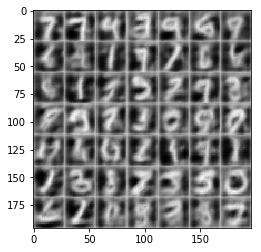

Epoch 2/2... Discriminator Loss: 1.3172... Generator Loss: 0.6038
Epoch 2/2... Discriminator Loss: 0.7166... Generator Loss: 2.4561
Epoch 2/2... Discriminator Loss: 0.7414... Generator Loss: 1.2499
Epoch 2/2... Discriminator Loss: 0.8523... Generator Loss: 1.2963
Epoch 2/2... Discriminator Loss: 0.6644... Generator Loss: 1.5305
Epoch 2/2... Discriminator Loss: 0.6230... Generator Loss: 2.0099
Epoch 2/2... Discriminator Loss: 1.2127... Generator Loss: 0.7568
Epoch 2/2... Discriminator Loss: 0.6622... Generator Loss: 1.5282
Epoch 2/2... Discriminator Loss: 0.8764... Generator Loss: 1.5270
Epoch 2/2... Discriminator Loss: 0.9058... Generator Loss: 2.5758


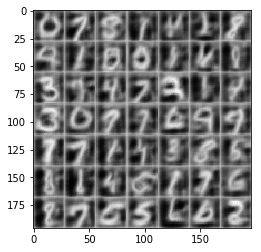

Epoch 2/2... Discriminator Loss: 0.5735... Generator Loss: 1.9756
Epoch 2/2... Discriminator Loss: 0.8286... Generator Loss: 2.6360
Epoch 2/2... Discriminator Loss: 0.7559... Generator Loss: 1.3068
Epoch 2/2... Discriminator Loss: 1.1816... Generator Loss: 0.7287
Epoch 2/2... Discriminator Loss: 0.4692... Generator Loss: 2.2629
Epoch 2/2... Discriminator Loss: 1.2272... Generator Loss: 0.6602
Epoch 2/2... Discriminator Loss: 0.8564... Generator Loss: 1.1282
Epoch 2/2... Discriminator Loss: 0.8334... Generator Loss: 1.2209
Epoch 2/2... Discriminator Loss: 1.1824... Generator Loss: 0.7111
Epoch 2/2... Discriminator Loss: 1.1632... Generator Loss: 0.7659


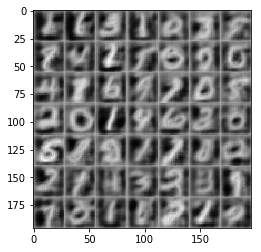

Epoch 2/2... Discriminator Loss: 0.5731... Generator Loss: 2.0300
Epoch 2/2... Discriminator Loss: 0.8894... Generator Loss: 0.9927
Epoch 2/2... Discriminator Loss: 0.9125... Generator Loss: 1.0206
Epoch 2/2... Discriminator Loss: 1.0904... Generator Loss: 0.9402
Epoch 2/2... Discriminator Loss: 0.7036... Generator Loss: 1.4437


In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.6897... Generator Loss: 20.9491
Epoch 1/1... Discriminator Loss: 0.9737... Generator Loss: 2.3802
Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 2.7145
Epoch 1/1... Discriminator Loss: 3.5114... Generator Loss: 0.2443
Epoch 1/1... Discriminator Loss: 1.1556... Generator Loss: 0.9190
Epoch 1/1... Discriminator Loss: 1.2648... Generator Loss: 5.5013
Epoch 1/1... Discriminator Loss: 0.5761... Generator Loss: 2.0088
Epoch 1/1... Discriminator Loss: 0.6578... Generator Loss: 2.9172
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 2.0120
Epoch 1/1... Discriminator Loss: 0.5397... Generator Loss: 2.7555


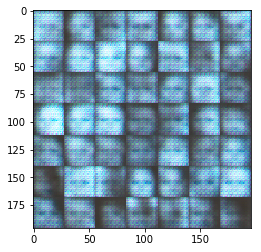

Epoch 1/1... Discriminator Loss: 0.4099... Generator Loss: 4.2130
Epoch 1/1... Discriminator Loss: 1.7219... Generator Loss: 5.8946
Epoch 1/1... Discriminator Loss: 0.6799... Generator Loss: 1.7423
Epoch 1/1... Discriminator Loss: 0.7229... Generator Loss: 1.3498
Epoch 1/1... Discriminator Loss: 2.0210... Generator Loss: 4.9703
Epoch 1/1... Discriminator Loss: 0.9056... Generator Loss: 1.5349
Epoch 1/1... Discriminator Loss: 1.7352... Generator Loss: 1.2695
Epoch 1/1... Discriminator Loss: 1.2913... Generator Loss: 0.8697
Epoch 1/1... Discriminator Loss: 2.0354... Generator Loss: 0.2949
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 1.7784


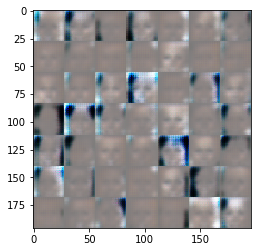

Epoch 1/1... Discriminator Loss: 1.2279... Generator Loss: 1.0261
Epoch 1/1... Discriminator Loss: 1.2441... Generator Loss: 1.3507
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.8034
Epoch 1/1... Discriminator Loss: 1.2470... Generator Loss: 1.1866
Epoch 1/1... Discriminator Loss: 1.2380... Generator Loss: 0.7465
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 1.4490
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.2311... Generator Loss: 0.8568
Epoch 1/1... Discriminator Loss: 0.9784... Generator Loss: 1.1443
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 1.6729


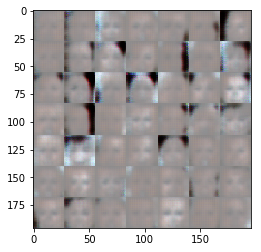

Epoch 1/1... Discriminator Loss: 2.1257... Generator Loss: 3.0752
Epoch 1/1... Discriminator Loss: 1.5662... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 1.3359... Generator Loss: 0.8488
Epoch 1/1... Discriminator Loss: 1.8373... Generator Loss: 0.3372
Epoch 1/1... Discriminator Loss: 1.1955... Generator Loss: 1.0455
Epoch 1/1... Discriminator Loss: 1.3765... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.6330... Generator Loss: 0.4075
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.1358... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.3604... Generator Loss: 2.0370


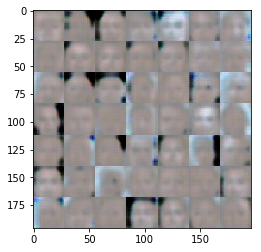

Epoch 1/1... Discriminator Loss: 0.9645... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 1.1708... Generator Loss: 1.1441
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.7930
Epoch 1/1... Discriminator Loss: 1.2161... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 1.4803
Epoch 1/1... Discriminator Loss: 1.0366... Generator Loss: 1.0494
Epoch 1/1... Discriminator Loss: 2.1009... Generator Loss: 2.8485
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.5636
Epoch 1/1... Discriminator Loss: 1.4161... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.0884... Generator Loss: 1.2155


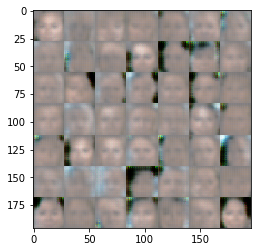

Epoch 1/1... Discriminator Loss: 1.1888... Generator Loss: 0.8969
Epoch 1/1... Discriminator Loss: 0.9896... Generator Loss: 1.2243
Epoch 1/1... Discriminator Loss: 1.5604... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.0334... Generator Loss: 1.1394
Epoch 1/1... Discriminator Loss: 1.4705... Generator Loss: 1.5844
Epoch 1/1... Discriminator Loss: 2.3791... Generator Loss: 2.5330
Epoch 1/1... Discriminator Loss: 1.5677... Generator Loss: 1.1821
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.1594... Generator Loss: 1.6314
Epoch 1/1... Discriminator Loss: 1.2633... Generator Loss: 0.8302


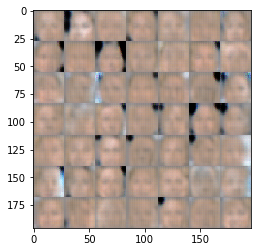

Epoch 1/1... Discriminator Loss: 1.8158... Generator Loss: 2.0085
Epoch 1/1... Discriminator Loss: 2.0210... Generator Loss: 1.5821
Epoch 1/1... Discriminator Loss: 1.3216... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.4919... Generator Loss: 0.6151
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 1.4738... Generator Loss: 1.8715
Epoch 1/1... Discriminator Loss: 1.3420... Generator Loss: 0.6118
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.6171
Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.3207... Generator Loss: 0.8779


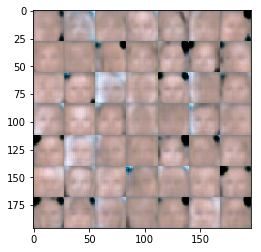

Epoch 1/1... Discriminator Loss: 1.3106... Generator Loss: 1.0336
Epoch 1/1... Discriminator Loss: 1.4172... Generator Loss: 0.9185
Epoch 1/1... Discriminator Loss: 1.3183... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.8133
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 1.3158... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.2810... Generator Loss: 0.7889
Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.3233... Generator Loss: 0.8000
Epoch 1/1... Discriminator Loss: 1.2936... Generator Loss: 0.7428


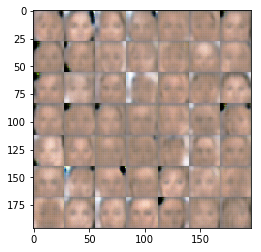

Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.8359
Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7596
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 1.0666
Epoch 1/1... Discriminator Loss: 1.4262... Generator Loss: 1.0635
Epoch 1/1... Discriminator Loss: 1.2525... Generator Loss: 0.9558
Epoch 1/1... Discriminator Loss: 1.4169... Generator Loss: 0.8468
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.8678
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.9121


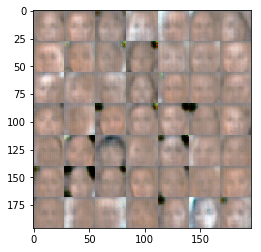

Epoch 1/1... Discriminator Loss: 1.5548... Generator Loss: 0.9136
Epoch 1/1... Discriminator Loss: 1.3477... Generator Loss: 1.2277
Epoch 1/1... Discriminator Loss: 1.4143... Generator Loss: 0.5915
Epoch 1/1... Discriminator Loss: 1.5156... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 2.0435... Generator Loss: 2.4335
Epoch 1/1... Discriminator Loss: 1.4663... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.3585... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.9918


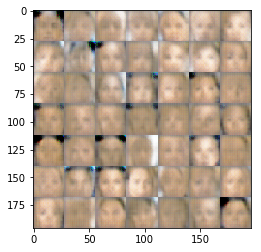

Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.9420
Epoch 1/1... Discriminator Loss: 1.2955... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.3579... Generator Loss: 0.6505
Epoch 1/1... Discriminator Loss: 1.4374... Generator Loss: 0.4836
Epoch 1/1... Discriminator Loss: 1.8950... Generator Loss: 0.2832
Epoch 1/1... Discriminator Loss: 1.2420... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.8621
Epoch 1/1... Discriminator Loss: 1.2899... Generator Loss: 0.8200
Epoch 1/1... Discriminator Loss: 1.4361... Generator Loss: 0.5103
Epoch 1/1... Discriminator Loss: 1.2935... Generator Loss: 0.9218


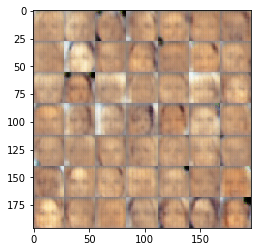

Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.6443
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.2206... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 1.2167... Generator Loss: 1.0565
Epoch 1/1... Discriminator Loss: 1.2009... Generator Loss: 0.8767
Epoch 1/1... Discriminator Loss: 1.3393... Generator Loss: 1.0909
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.8040
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 0.9710
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.8449
Epoch 1/1... Discriminator Loss: 1.2800... Generator Loss: 0.9287


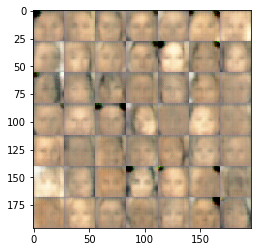

Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 1.2557
Epoch 1/1... Discriminator Loss: 1.5245... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 1.3751... Generator Loss: 0.9222
Epoch 1/1... Discriminator Loss: 1.5887... Generator Loss: 1.8788
Epoch 1/1... Discriminator Loss: 1.2616... Generator Loss: 1.1038
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 1.1435
Epoch 1/1... Discriminator Loss: 1.2762... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 1.3385
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.5144
Epoch 1/1... Discriminator Loss: 1.3279... Generator Loss: 0.6344


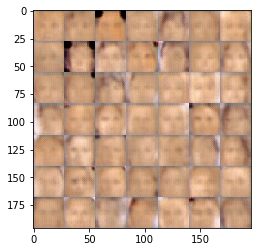

Epoch 1/1... Discriminator Loss: 1.3679... Generator Loss: 0.6377
Epoch 1/1... Discriminator Loss: 1.4251... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.9289
Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.4175
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.6002
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 1.0412
Epoch 1/1... Discriminator Loss: 1.4730... Generator Loss: 0.5593
Epoch 1/1... Discriminator Loss: 1.6584... Generator Loss: 0.3439
Epoch 1/1... Discriminator Loss: 1.1943... Generator Loss: 1.0696


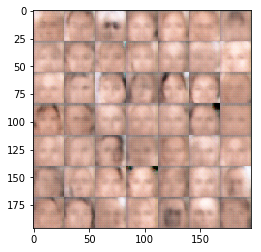

Epoch 1/1... Discriminator Loss: 1.3360... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 1.0117
Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.7684
Epoch 1/1... Discriminator Loss: 1.1835... Generator Loss: 1.1397
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.4811
Epoch 1/1... Discriminator Loss: 1.3245... Generator Loss: 1.1777
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.3929... Generator Loss: 1.5122
Epoch 1/1... Discriminator Loss: 2.2752... Generator Loss: 2.7175
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6359


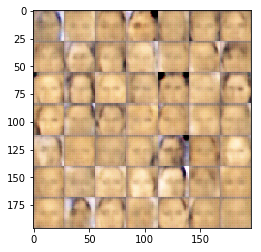

Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.8634
Epoch 1/1... Discriminator Loss: 1.3704... Generator Loss: 0.8760
Epoch 1/1... Discriminator Loss: 1.4712... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.8982
Epoch 1/1... Discriminator Loss: 1.2126... Generator Loss: 1.0804
Epoch 1/1... Discriminator Loss: 1.2481... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.7191
Epoch 1/1... Discriminator Loss: 1.4536... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 2.4298... Generator Loss: 3.1071
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.5308


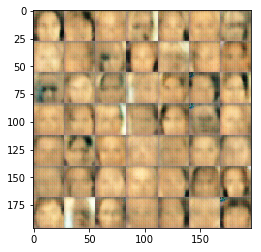

Epoch 1/1... Discriminator Loss: 1.3178... Generator Loss: 0.8889
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.6931
Epoch 1/1... Discriminator Loss: 1.3018... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.8142
Epoch 1/1... Discriminator Loss: 1.4543... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.2692... Generator Loss: 1.0960
Epoch 1/1... Discriminator Loss: 1.2989... Generator Loss: 0.8346
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.5423
Epoch 1/1... Discriminator Loss: 0.9406... Generator Loss: 1.2323
Epoch 1/1... Discriminator Loss: 2.2317... Generator Loss: 2.8455


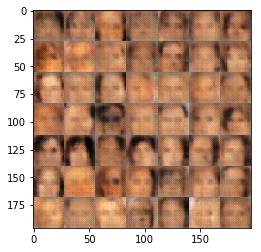

Epoch 1/1... Discriminator Loss: 1.3113... Generator Loss: 0.9969
Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7188
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.2650... Generator Loss: 0.9288
Epoch 1/1... Discriminator Loss: 1.4651... Generator Loss: 0.9967
Epoch 1/1... Discriminator Loss: 1.3865... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.3486... Generator Loss: 0.8242
Epoch 1/1... Discriminator Loss: 1.9100... Generator Loss: 1.6932
Epoch 1/1... Discriminator Loss: 1.1914... Generator Loss: 0.7635


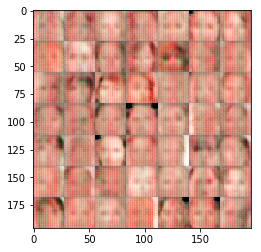

Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.9009
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.9801
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.8269
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.6688
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 0.6403
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.5993... Generator Loss: 0.4016
Epoch 1/1... Discriminator Loss: 1.2787... Generator Loss: 0.8598
Epoch 1/1... Discriminator Loss: 1.4857... Generator Loss: 1.3193


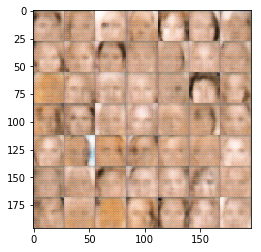

Epoch 1/1... Discriminator Loss: 1.4880... Generator Loss: 0.7997
Epoch 1/1... Discriminator Loss: 1.4153... Generator Loss: 0.6718
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3880... Generator Loss: 0.8805
Epoch 1/1... Discriminator Loss: 1.4170... Generator Loss: 0.8868
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7717
Epoch 1/1... Discriminator Loss: 1.3957... Generator Loss: 0.6035
Epoch 1/1... Discriminator Loss: 1.2976... Generator Loss: 1.1300
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.3077... Generator Loss: 0.7603


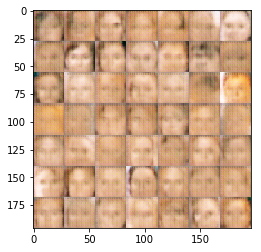

Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.7541
Epoch 1/1... Discriminator Loss: 1.6626... Generator Loss: 0.3616
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 1.3266... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.3533... Generator Loss: 0.9559
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 1.0859
Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.6850
Epoch 1/1... Discriminator Loss: 1.4590... Generator Loss: 0.5809
Epoch 1/1... Discriminator Loss: 1.6952... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.5961... Generator Loss: 1.6403


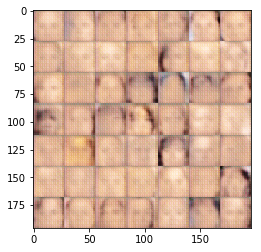

Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.8315
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.5099... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 1.3306
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.8216
Epoch 1/1... Discriminator Loss: 1.2635... Generator Loss: 0.8447
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7840
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.9069
Epoch 1/1... Discriminator Loss: 1.3518... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 1.3551


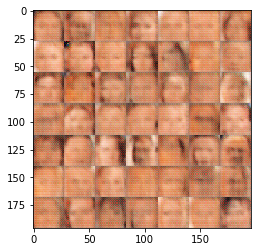

Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.6769
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.5476
Epoch 1/1... Discriminator Loss: 1.3184... Generator Loss: 0.8336
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7643
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.2313... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.5773... Generator Loss: 0.5365
Epoch 1/1... Discriminator Loss: 1.3745... Generator Loss: 0.9813
Epoch 1/1... Discriminator Loss: 1.3652... Generator Loss: 0.8921
Epoch 1/1... Discriminator Loss: 1.3673... Generator Loss: 0.9132


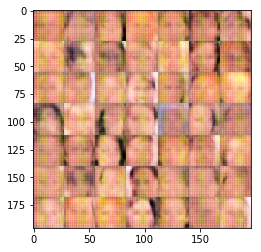

Epoch 1/1... Discriminator Loss: 1.3552... Generator Loss: 0.8641
Epoch 1/1... Discriminator Loss: 1.4192... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.8524
Epoch 1/1... Discriminator Loss: 1.3697... Generator Loss: 0.8106
Epoch 1/1... Discriminator Loss: 1.4141... Generator Loss: 0.6224
Epoch 1/1... Discriminator Loss: 1.2709... Generator Loss: 1.1120
Epoch 1/1... Discriminator Loss: 1.3897... Generator Loss: 1.0554
Epoch 1/1... Discriminator Loss: 1.3635... Generator Loss: 0.7551
Epoch 1/1... Discriminator Loss: 1.3530... Generator Loss: 0.9990
Epoch 1/1... Discriminator Loss: 1.2710... Generator Loss: 0.9525


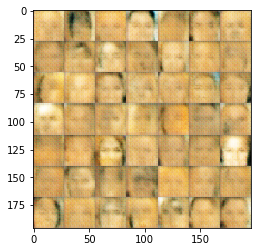

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.5234... Generator Loss: 0.5348
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.4371... Generator Loss: 1.0276
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.7787
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.6083
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.7634
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.8417
Epoch 1/1... Discriminator Loss: 1.3471... Generator Loss: 0.9545
Epoch 1/1... Discriminator Loss: 1.4367... Generator Loss: 0.6781


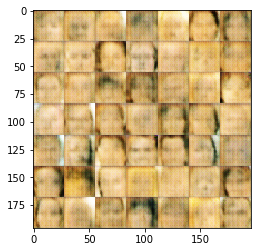

Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.6949
Epoch 1/1... Discriminator Loss: 1.4256... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.3079... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.3950... Generator Loss: 0.9930
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.6844
Epoch 1/1... Discriminator Loss: 1.3712... Generator Loss: 0.8949
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.3713... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.3120... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.4522... Generator Loss: 0.7857


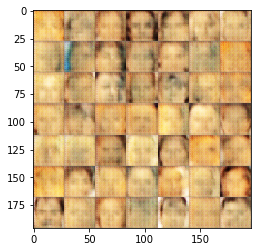

Epoch 1/1... Discriminator Loss: 1.2891... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.5500
Epoch 1/1... Discriminator Loss: 1.3551... Generator Loss: 0.8922
Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7404
Epoch 1/1... Discriminator Loss: 1.4755... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.3520... Generator Loss: 0.8382
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 1.0180
Epoch 1/1... Discriminator Loss: 1.5004... Generator Loss: 0.6627
Epoch 1/1... Discriminator Loss: 1.1405... Generator Loss: 1.1396


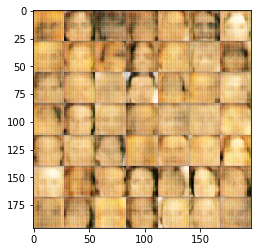

Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3633... Generator Loss: 0.7856
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.7321
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7681
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.8374
Epoch 1/1... Discriminator Loss: 1.4038... Generator Loss: 0.6295


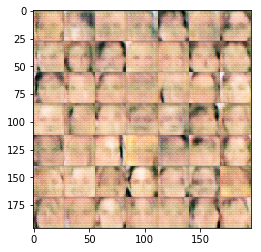

Epoch 1/1... Discriminator Loss: 1.3807... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3614... Generator Loss: 0.8503
Epoch 1/1... Discriminator Loss: 1.5544... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.4452... Generator Loss: 0.5952
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.9032
Epoch 1/1... Discriminator Loss: 1.2759... Generator Loss: 1.0149
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7986
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.7074
Epoch 1/1... Discriminator Loss: 1.2873... Generator Loss: 0.7883
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.7698


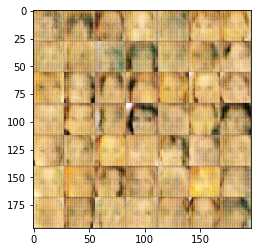

Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.3947... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.3785... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.3511... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.3121... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.3602... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.2704... Generator Loss: 1.0059
Epoch 1/1... Discriminator Loss: 1.3694... Generator Loss: 0.6873


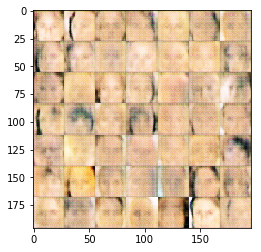

Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.9102
Epoch 1/1... Discriminator Loss: 1.3417... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6467
Epoch 1/1... Discriminator Loss: 1.2993... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.2085... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 1.2713... Generator Loss: 1.0131
Epoch 1/1... Discriminator Loss: 1.4735... Generator Loss: 0.8920
Epoch 1/1... Discriminator Loss: 1.4271... Generator Loss: 0.6642


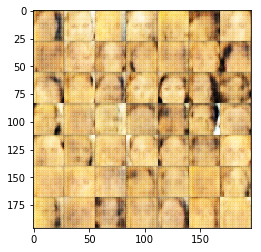

Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.6492
Epoch 1/1... Discriminator Loss: 1.5123... Generator Loss: 0.8512
Epoch 1/1... Discriminator Loss: 1.3100... Generator Loss: 0.6698
Epoch 1/1... Discriminator Loss: 1.4559... Generator Loss: 0.7958
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 1.0474
Epoch 1/1... Discriminator Loss: 1.3342... Generator Loss: 0.8417


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.